In [14]:
import pandas as pd
import numpy as np
import nltk
import requests
import re
import json

from nltk import ngrams

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch

import seaborn as sns

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [2]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
conf = sddk.configure()

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
occupations = gc.open_by_url("https://docs.google.com/spreadsheets/d/1nONTEwp42CVnq3iCiONrFbJedIcYtBV-l4Bil5mU7Eo/edit?usp=sharing")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [58]:
# login to our project folder
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [5]:
# read edh dataset
publicfolder = "e0f9cd400dd05584fe06fe1d804deff0"
EDH = sddk.read_file("EDH_occupsorgs_2021-02-26.json", "df", publicfolder)
EDCS = sddk.read_file("EDCS_occupsorgs_2021-02-26.json", "df", publicfolder)

reading file located in a public folder
reading file located in a public folder


In [31]:
# read and execute our script for modelling dates
script_url = "https://raw.githubusercontent.com/sdam-au/tempun/master/scripts/modelling_distributions.py"
# execute the script
exec(requests.get(script_url).content)

In [7]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
EDH["random_dates"] = EDH.apply(lambda row: model_date(row["not_before"], row["not_after"], size=1000,), axis=1)
# EDCS["random_dates"] = EDCS.apply(lambda row: model_date(row["dating from"], row["dating to"], size=1000,), axis=1)

CPU times: user 27.3 s, sys: 605 ms, total: 27.9 s
Wall time: 28 s


# Inscription types over time

In [8]:
simulations_by_type_len = []

for ins_type in EDH["type_of_inscription_clean"].unique():
    if ins_type != "NULL":
        subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type]
        simulations_by_type_len.append((ins_type, len(subset_df)))
simulations_by_type_len = sorted(simulations_by_type_len, key = lambda x: x[1], reverse=True)
simulations_by_type_len

[('epitaph', 27953),
 ('votive inscription', 14044),
 ('owner/artist inscription', 5185),
 ('honorific inscription', 3999),
 ('building/dedicatory inscription', 3307),
 ('mile-/leaguestone', 1730),
 ('identification inscription', 1574),
 ('acclamation', 533),
 ('military diploma', 500),
 ('list', 360),
 ('defixio', 309),
 ('label', 289),
 ('public legal inscription', 248),
 ('boundary inscription', 246),
 ('elogium', 143),
 ('letter', 121),
 ('seat inscription', 87),
 ('prayer', 56),
 ('private legal inscription', 45),
 ('assignation inscription', 16),
 ('calendar', 14),
 ('adnuntiatio', 3)]

In [9]:
simulations_by_type = []

for ins_type_tup in simulations_by_type_len[:10]:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    simulations = timeblocks_from_randoms(subset_df, "random_dates", [-200, 600, 100])
    ins_type_N =len(subset_df)
    simulations_by_type.append([ins_type_tup[0],ins_type_N, simulations]) 
simulations_by_type = sorted(simulations_by_type, key=lambda x: x[1], reverse=True)

In [10]:
simulations_by_type = sorted(simulations_by_type, key=lambda x: x[1], reverse=True)

In [20]:
simulations_by_type[4][1]

3307

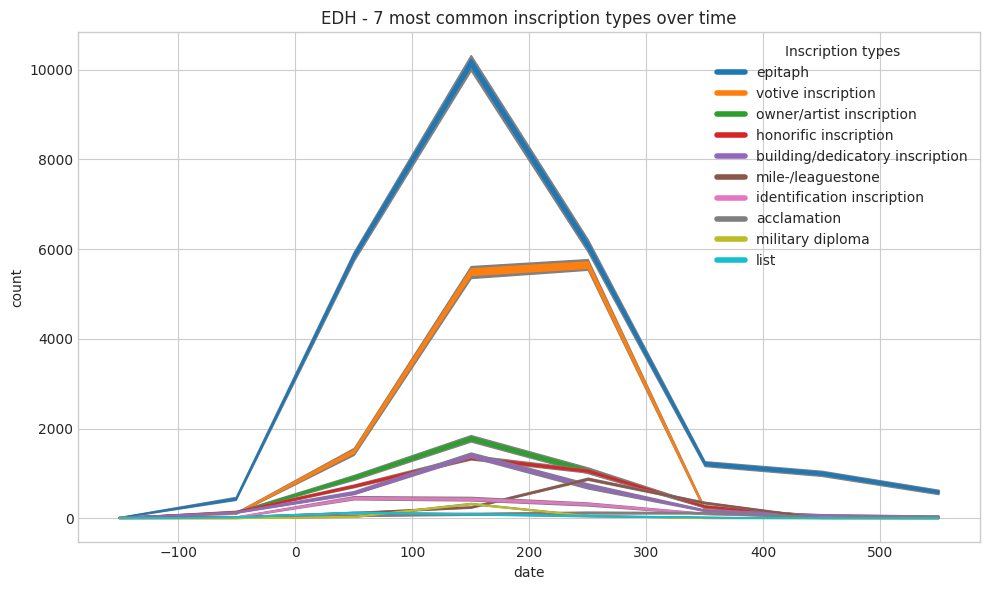

In [32]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-whitegrid")

fig, ax  = plt.subplots(figsize=(10, 6), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type, tab_colors_list[:len(simulations_by_type)]):
    plot_timeblocks_data(ins_type_sims[2], ax=ax, color=color)
    
ax.set_xlabel("date")
ax.set_ylabel("count")
ax.set_title("EDH - 7 most common inscription types over time")
 
markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in tab_colors_list[:len(simulations_by_type)]]
plt.legend(markers, [tup[0] for tup in simulations_by_type], numpoints=1,  title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

In [285]:
sddk.write_file("SDAM_data/social_diversity/EDH_inscription_types_temporal.png", fig, conf)

A file with the same name ("EDH_inscription_types_temporal.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_inscription_types_temporal.png"


In [33]:
def wordcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()

def wordcount_avg(timeblock_df, column="clean_text_interpretive_word"):
    """average number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum() / len(timeblock_df)

def charcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of characters in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()

def charcount_avg(timeblock_df, column="clean_text_interpretive_word"):
    """average number of characters in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x)).sum() / len(timeblock_df)

def unique_words(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique words in inscriptions within timeblock"""
    inscriptions_list = timeblock_df[column].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words

def unique_words_weighted(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique words in inscriptions within timeblock
    in proportion to total number of words"""
    wordcount = timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()
    inscriptions_list = timeblock_df[column].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words / wordcount

def extract_ngrams(text, width=4):
    """extracts character ngrams from a string of given width
    returns: list of ngrams"""
    char_ngrams = ["".join(ngram) for ngram in list(ngrams(str(text), width))]
    return char_ngrams

def unique_ngrams(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique ngrams in inscriptions within timeblock"""
    ngrams_series = timeblock_df[column].astype(str).apply(extract_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique)

def unique_ngrams_weighted(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique ngrams in inscriptions within timeblock
    in proportion to total number of characters"""
    ngrams_series = timeblock_df[column].astype(str).apply(extract_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique) / charcount


In [76]:
# N of occuptions and N of organization per inscription category
ins_types_occs_orgs = []
for ins_type_tup in simulations_by_type_len:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    occ_N = subset_df["occups_N"].sum()
    orgs_N = subset_df["organizations_N"].sum()
    ins_types_occs_orgs.append([ins_type_tup[0] + " (N={0})".format(len(subset_df)), occ_N, orgs_N])
    print("inscription type: {0}, N of occupations: {1}, N of organizations: {2}".format(ins_type_tup[0], str(occ_N), str(orgs_N)))

inscription type: epitaph, N of occupations: 565, N of organizations: 282
inscription type: votive inscription, N of occupations: 345, N of organizations: 150
inscription type: owner/artist inscription, N of occupations: 24, N of organizations: 0
inscription type: honorific inscription, N of occupations: 218, N of organizations: 87
inscription type: building/dedicatory inscription, N of occupations: 103, N of organizations: 48
inscription type: mile-/leaguestone, N of occupations: 0, N of organizations: 0
inscription type: identification inscription, N of occupations: 12, N of organizations: 0
inscription type: acclamation, N of occupations: 5, N of organizations: 0
inscription type: military diploma, N of occupations: 77, N of organizations: 0
inscription type: list, N of occupations: 47, N of organizations: 16
inscription type: defixio, N of occupations: 5, N of organizations: 5
inscription type: label, N of occupations: 0, N of organizations: 0
inscription type: public legal inscrip

In [77]:
pd.DataFrame(ins_types_occs_orgs, columns=["inscription type", "occupations", "organisations"])

,inscription type,occupations,organisations
0,epitaph (N=27953),565,282
1,votive inscription (N=14044),345,150
2,owner/artist inscription (N=5185),24,0
3,honorific inscription (N=3999),218,87
4,building/dedicatory inscription (N=3307),103,48
5,mile-/leaguestone (N=1730),0,0
6,identification inscription (N=1574),12,0
7,acclamation (N=533),5,0
8,military diploma (N=500),77,0
9,list (N=360),47,16


In [78]:
EDH["occups_N"].sum()

2268

In [111]:
types, occups_freqs, orgs_freqs = [], [], [] 

for ins_type_tup in simulations_by_type_len[:10][::-1]: # for horizontal bar below, we need the list in reverse order, therefore: [::-1]
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    subset_wordcount = wordcount(subset_df).sum()
    types.append(ins_type_tup[0])
    occups_freqs.append(subset_df["occups_N"].sum() / subset_wordcount * 1000)
    orgs_freqs.append(subset_df["organizations_N"].sum() / subset_wordcount * 1000)

In [103]:
height = 0.35
y = np.arange(len(types))
y + height/2

array([0.175, 1.175, 2.175, 3.175, 4.175, 5.175, 6.175, 7.175, 8.175,
       9.175])

In [ ]:
y + 

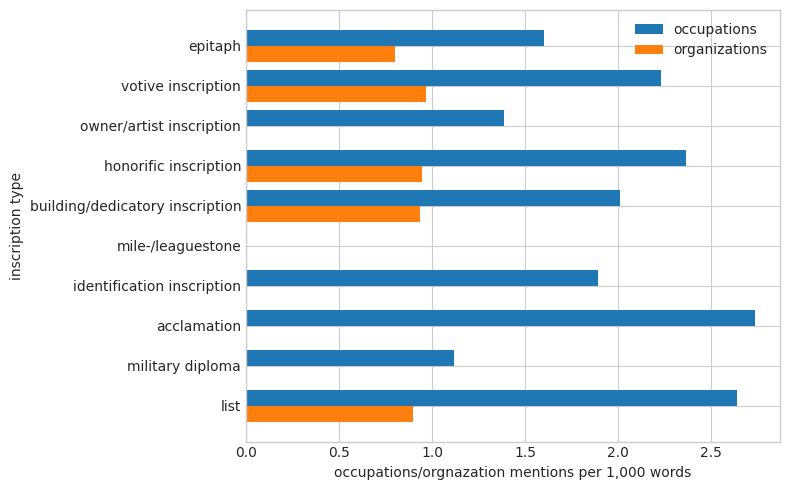

In [117]:
fig, ax  = plt.subplots(figsize=(8, 5), tight_layout=True)

y = np.arange(len(types))
height = 0.4

ax.barh(y + height/2, occups_freqs, height, label="occupations") #, color=tab_colors_list[:len(simulations_by_type)])
ax.barh(y - height/2, orgs_freqs, height, label="organizations") #, color=tab_colors_list[:len(simulations_by_type)])

ax.set_yticks(y) #y_pos, types)
ax.set_yticklabels(types) #, rotation="vertical")
ax.set_xlabel("occupations/orgnazation mentions per 1,000 words")
ax.set_ylabel("inscription type")
ax.legend()

In [118]:
sddk.write_file("SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.png"


# Wordcount & character count over time

In [60]:
charcounts_data = sim_data_by_function(EDH, 100, [-200, 600, 50], charcount)

In [61]:
charcounts_data[0]

[((-200, -151), 17925),
 ((-150, -101), 15363),
 ((-100, -51), 31800),
 ((-50, -1), 85635),
 ((1, 50), 442663),
 ((51, 100), 573803),
 ((101, 150), 977007),
 ((151, 200), 1214647),
 ((201, 250), 1207404),
 ((251, 300), 517893),
 ((301, 350), 178636),
 ((351, 400), 124937),
 ((401, 450), 55882),
 ((451, 500), 34864),
 ((501, 550), 24609),
 ((551, 600), 30966)]

In [62]:
%%time
wordcounts_data = sim_data_by_function(EDH, 100, [-200, 600, 50], wordcount) 
wordcounts_avg_data = sim_data_by_function(EDH, 100, [-200, 600, 50], wordcount_avg) 
charcounts_data = sim_data_by_function(EDH, 100, [-200, 600, 50], charcount) 
charcounts_avg_data = sim_data_by_function(EDH, 100, [-200, 600, 50], charcount_avg) 
unique_words_data = sim_data_by_function(EDH, 100, [-200, 600, 50], unique_words)
unique_ngrams_data = sim_data_by_function(EDH, 100, [-200, 600, 50], unique_ngrams)

KeyboardInterrupt: 

In [63]:
sim_data_list = [
    (wordcounts_data, "(A) EDH - wordcounts", "wordcount"),
    (wordcounts_avg_data, "(B) EDH - average wordcounts per inscription", "avr. wordcount"),
    (charcounts_data,  "(C) EDH - character counts", "character count"),
    (charcounts_avg_data, "(D) EDH - average character counts per inscription", "avr. char. count"),
    (unique_words_data, "(E) EDH - unique words counts", "count"),
    (unique_ngrams_data, "(F) EDH - unique character four-grams", "count")]

NameError: name 'unique_ngrams_data' is not defined

In [ ]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
tab_colors_list

In [ ]:
max([el[1] for el in wordcounts_data[0]])

In [ ]:
plt.style.use("seaborn-whitegrid")

fig, axs  = plt.subplots(3, 2, figsize=(12, 8), tight_layout=True)

for sim_data, ax, color in zip(sim_data_list, axs.ravel(), tab_colors_list[:len(sim_data_list)]):
    plot_timeblocks_data(sim_data[0], ax, color)
    ax.set_title(sim_data[1])
    ax.set_ylabel(sim_data[2])
    if max([el[1] for el in sim_data[0][0]]) > 5000:
        ticks = list(ax.get_yticks())
        print(ticks)
        ticks_K = [str(int(int(tick) / 1000)) + "K" if tick != 0 else tick for tick in ticks]
        ax.set_yticklabels(ticks_K)

In [201]:
sddk.write_file("SDAM_data/social_diversity/EDH_word+char_counts_temporal.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_word+char_counts_temporal.png"


# Occupations over centuries

In [ ]:
# read declined occupations
with open("../data/occups_declined_dict.json", "r") as fp:
    occups_declined_dict = json.load(fp)

# check that our occupations are properly arranged (from the longest...)
list(occups_declined_dict.keys())[:20]

In [91]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
EDH["random_dates"] = EDH.apply(lambda row: model_date(row["not_before"], row["not_after"], size=1000,), axis=1)
# EDCS["random_dates"] = EDCS.apply(lambda row: model_date(row["dating from"], row["dating to"], size=1000,), axis=1)

CPU times: user 29.9 s, sys: 515 ms, total: 30.5 s
Wall time: 30.5 s


In [116]:
%%time
EDH_complete_simulations = timeblocks_from_randoms(EDH, "random_dates", [-200, 600, 100])
# look at the first one
EDH_complete_simulations[0]

CPU times: user 16.1 s, sys: 87.6 ms, total: 16.2 s
Wall time: 16.2 s


[((-200, -101), 116),
 ((-100, -1), 1292),
 ((1, 100), 11673),
 ((101, 200), 23455),
 ((201, 300), 17660),
 ((301, 400), 3019),
 ((401, 500), 1392),
 ((501, 600), 821)]

In [139]:
def get_date_from_randoms(value, n):
    try:
        return value[n]
    except:
        return None

def sim_data(df, n_sims, metrics_function, *args):
    complete_sim_data = []
    for n in range(n_sims):
        sim = df["random_dates"].apply(lambda x: get_date_from_randoms(x, n))
        sim_data = []
        for tb in get_timeblocks(-200, 600, 100):
            mask = sim.between(tb[0], tb[1])
            df_tb = df[mask]
            function_output = metrics_function(df_tb, *args)
            sim_data.append((tb, function_output))
        complete_sim_data.append(sim_data)
    return complete_sim_data

In [122]:
len(set([el for sublist in EDH["occups"].tolist() for el in sublist]))

267

In [143]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def occups_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["occups_N"] > 0])
    return occups_N_sum / len(timeblock_df)

# various metrics on the level of timeblocks
def occups_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["occups_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return occups_N_sum / wordcount

# various metrics on the level of timeblocks
def unique_occups(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    return unique_occups

# unique occups / inscriptions
def unique_occups_ins_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    return unique_occups / len(timeblock_df)


# various metrics on the level of timeblocks
def unique_occups_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_occups / unique_words

In [166]:
EDH_complete_simulations[0]

[((-200, -101), 116),
 ((-100, -1), 1292),
 ((1, 100), 11673),
 ((101, 200), 23455),
 ((201, 300), 17660),
 ((301, 400), 3019),
 ((401, 500), 1392),
 ((501, 600), 821)]

In [190]:
counts_data = sim_data_by_function(EDH, 100, [-200, 600, 100], occups_count) 
occups_ins_ratio = sim_data_by_function(EDH, 100, [-200, 600, 100], occups_inscriptions_ratio)
occups_TF_data = sim_data_by_function(EDH, 100, [-200, 600, 100], occups_cumulTF) 
unique_occups_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_occups) 
unique_occups_ratio_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_occups_ratio) 
unique_occups_ins_ratio_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_occups_ins_ratio)

In [194]:
sim_data_occups_list = [
    (counts_data, "(A) EDH - occupations count", "occupation mentions count"),
    (occups_ins_ratio, "(B) EDH - occupations/inscriptions", "inscriptions with occupations\n/inscriptions count ratio"),
    (occups_TF_data, "(C) EDH - occupations/wordcount", "occupation mentions\n/wordcount ratio"),
    (unique_occups_data, "(D) EDH - unique occupations", "unique occupations"),
    (unique_occups_ratio_data, "(E) EDH - unique occupations/unique words", "unique occupations\n/unique words"),
    (unique_occups_ins_ratio_data, "(E) EDH - unique occupations/inscriptions", "unique occupations\n/inscriptions")     
]

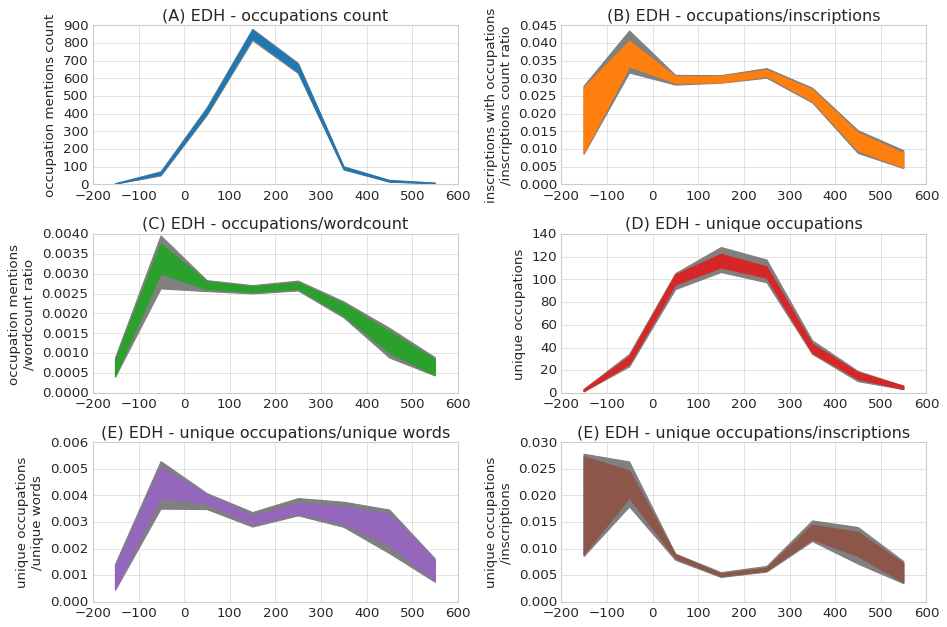

In [195]:
plt.style.use("seaborn-whitegrid")

fig, axs  = plt.subplots(3, 2, figsize=(12, 8), tight_layout=True)

for sim_data, ax, color in zip(sim_data_occups_list, axs.ravel(), tab_colors_list[:len(sim_data_list)]):
    plot_timeblocks_data(sim_data[0], ax, color)
    ax.set_title(sim_data[1])
    ax.set_ylabel(sim_data[2])
    if max([el[1] for el in sim_data[0][0]]) > 5000:
        ticks = list(ax.get_yticks())
        print(ticks)
        ticks_K = [str(int(int(tick) / 1000)) + "K" if tick != 0 else tick for tick in ticks]
        ax.set_yticklabels(ticks_K)

In [199]:
sddk.write_file("SDAM_data/social_diversity/EDH_occups_temporal.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_occups_temporal.png"
